In [21]:
from pulp import *
from scipy.io import loadmat
import pandas as pd
import numpy as np
from MultiDimensionalLpVariable import MultiDimensionalLpVariable

# 输入园区历史负荷曲线
day01 = np.matrix(pd.read_excel("dayInput.xlsx",sheet_name="day01").T)
day02 = np.matrix(pd.read_excel("dayInput.xlsx",sheet_name="day02").T)
day03 = np.matrix(pd.read_excel("dayInput.xlsx",sheet_name="day03").T)
day04 = np.matrix(pd.read_excel("dayInput.xlsx",sheet_name="day04").T)
day05 = np.matrix(pd.read_excel("dayInput.xlsx",sheet_name="day05").T)
day06 = np.matrix(pd.read_excel("dayInput.xlsx",sheet_name="day06").T)
day07 = np.matrix(pd.read_excel("dayInput.xlsx",sheet_name="day07").T)
day08 = np.matrix(pd.read_excel("dayInput.xlsx",sheet_name="day08").T)
c = np.hstack((day01,day02,day03,day04,day05,day06,day07,day08))
Load_E = c[0,:]
# print(Load_E)
Load_C = c[1,:]
Load_H = c[2,:]
kNumber = 8
Max_Load_scene= kNumber*24
proportionTypicalday=np.array([65/365,26/365,66/365,26/365,65/365,26/365,65/365,26/365])
# 历史电价
priceElectricityDay = np.matrix(pd.read_excel("priceElectricity.xlsx"))

# 设备参数
priceGas = 3.3
planningYears = 10
cchpTypes = 6
gbTypes = 10
acTypes = 32
ebTypes = 20
subTypes = 30
nSub = 1
nEMin = 0.35
nEMax = 0.4
nE = np.matrix(np.linspace(start=nEMin,stop=nEMax,num = cchpTypes))
nHMin = 0.4
nHMax = 0.45
nH = np.matrix(np.linspace(start=nHMin,stop=nHMax,num = cchpTypes))
copC = 1.2
copH = 0.9
nGb = 0.8
copAc = 2.5
nEbMin = 0.9
nEbMax = 0.95
nEb = np.matrix(np.linspace(start=nEbMin,stop=nEbMax,num = ebTypes))
lhv = 35.544/3.6

# 构建能量耦合矩阵
converterSub = np.tile(np.matrix([[nSub],[0],[0]]),subTypes)
converterCchp = np.bmat([[nE],[nH * copC],[nH * copH]])
converterGb = np.tile(np.matrix([[0],[0],[nGb]]),gbTypes)
converterAc = np.tile(np.matrix([[0],[copAc],[0]]),acTypes)
converterEb = np.bmat([[np.zeros((1,ebTypes))],[np.zeros((1,ebTypes))],[nEb]])
CMatrix = np.hstack((converterSub,converterCchp,converterGb,converterAc,converterEb))

#建设方案成本
cchpCapacityMin = 800
cchpCapacityMax = 3800
cchpCapacity = np.matrix(np.linspace(start=cchpCapacityMin,stop=cchpCapacityMax,num = cchpTypes))
cchpCost = cchpCapacity * 300

gbCapacityMin = 500
gbCapacityMax = 5000
gbCapacity = np.matrix(np.linspace(start=gbCapacityMin,stop=gbCapacityMax,num = gbTypes))
gbCost = gbCapacity * 70

acCapacityMin = 500
acCapacityMax = 16000
acCapacity = np.matrix(np.linspace(start=acCapacityMin,stop=acCapacityMax,num = acTypes) / copAc)
acCost = acCapacity * copAc * 870

ebCapacityMin = 250
ebCapacityMax = 5000
ebCapacity = np.matrix(np.linspace(start=ebCapacityMin,stop=ebCapacityMax,num = ebTypes))
ebCost = ebCapacity * 55

subCapacityMin = 500
subCapacityMax = 15000
subCapacity = np.matrix(np.linspace(start=subCapacityMin,stop=subCapacityMax,num = subTypes))
subCost = subCapacity * 4

# 定义选型的种类，即优化变量的维度
subTypes=30
cchpTypes=6
gbTypes=10
acTypes=32
ebTypes=20

SUB_types=range(subTypes)
CCHP_types=range(cchpTypes)
GB_types=range(gbTypes)
AC_types=range(acTypes)
EB_types=range(ebTypes)

# P=sdpvar(SUB_types+CCHP_types+GB_types+AC_types+EB_types,Load_scene,'full');
P_rangeset=range(subTypes+cchpTypes+gbTypes+acTypes+ebTypes)

Load_scene=range(Max_Load_scene)

# Create the 'prob' variable to contain the problem data
prob=LpProblem('Plan_EB1', LpMinimize)

# 优化模型中的变量声明

X_CCHP = MultiDimensionalLpVariable("X_CCHP", (cchpTypes,1), 0, 1, LpBinary)
X_GB = MultiDimensionalLpVariable("X_GB", (gbTypes,1), 0, 1, LpBinary)
X_AC = MultiDimensionalLpVariable("X_AC", (acTypes,1), 0, 1, LpBinary)
X_EB = MultiDimensionalLpVariable("X_EB", (ebTypes,1), 0, 1, LpBinary)
X_SUB = MultiDimensionalLpVariable("X_SUB", (subTypes,1), 0, 1, LpBinary)

# 机组耗电耗气连续变量
P_CCHP_gas= MultiDimensionalLpVariable("P_CCHP_Gas",(Max_Load_scene,cchpTypes),0,None,LpContinuous)    # CCHP单位时间内所用燃气热值，单位是MW（应该修改成kw比较合适）
V_CCHP_gas= MultiDimensionalLpVariable("V_CCHP_Gas",(Max_Load_scene,cchpTypes),0,None,LpContinuous)    # CCHP单位时间内所用燃气量，单位是m3/h
P_SUB_electricity=MultiDimensionalLpVariable("P_SUB",(Max_Load_scene,subTypes),0,None,LpContinuous)     # 变电站出力，单位是MW
P_GB_gas=MultiDimensionalLpVariable("P_GB_Gas",(Max_Load_scene,gbTypes),0,None,LpContinuous)        # GB单位时间内所用燃气热值，单位是MW
V_GB_gas=MultiDimensionalLpVariable("V_GB_Gas",(Max_Load_scene,gbTypes),0,None,LpContinuous)        # GB单位时间内所用燃气量，单位是m3/h
P_AC_electricity=MultiDimensionalLpVariable("P_AC",(Max_Load_scene,acTypes),0,None,LpContinuous) # 中央空调输入电出力，单位MW
P_EB_electricity=MultiDimensionalLpVariable("P_EB",(Max_Load_scene,ebTypes),0,None,LpContinuous) # 电锅炉输入电能，单位MW

P=MultiDimensionalLpVariable("P",(subTypes+cchpTypes+gbTypes+acTypes+ebTypes,Max_Load_scene),0,None,LpContinuous)
L=MultiDimensionalLpVariable("L",(3,Max_Load_scene),0,None,LpContinuous)

# Constraints
# for t in Load_scene:
#     prob += P[:,t].T==[P_SUB_electricity[t,:],P_CCHP_gas[t,:],P_GB_gas[t,:],P_AC_electricity[t,:],P_EB_electricity[t,i]]

for t in Load_scene:
    for i in SUB_types:
        prob += P[i,t]==P_SUB_electricity[t,i] #,"Power Transfor %s" % t*i # Name of constraints cannot be too long due to the fact that it would be stored in a MPS file
    for i in CCHP_types:
        j = i+subTypes
        prob += P[j,t]==P_CCHP_gas[t,i] #,"Power Transfor %s" % t*i
    for i in GB_types:
        j = i+subTypes+cchpTypes
        prob += P[j,t]==P_GB_gas[t,i] #,"Power Transfor %s" % t*i
    for i in AC_types:
        j = i+subTypes+cchpTypes+gbTypes
        prob += P[j,t]==P_AC_electricity[t,i]#,"Power Transfor %s" % t*i
    for i in EB_types:
        j = i+subTypes+cchpTypes+gbTypes+acTypes
        prob += P[j,t]==P_EB_electricity[t,i]#,"Power Transfor %s" % t*i
print('Energy Hub 输入矩阵构建完成！')

#  负荷平衡
for t in Load_scene:
    i=0
    prob += L[i,t] == Load_E[0,t]+lpSum(P_AC_electricity[t,j] for j in AC_types)+\
        lpSum(P_EB_electricity[t,j] for j in EB_types)
    i=1
    prob += L[i,t] == Load_C[0,t]
    i=2
    prob += L[i,t] == Load_H[0,t]
print('Energy Hub 输出矩阵构建完成！')

#  负荷平衡
for t in Load_scene:
    i=0
    prob += L[i,t] == lpSum(CMatrix[0,j]*P[j,t] for j in P_rangeset)#, "电负荷平衡 %s" % t
    i=1
    prob += L[i,t] <= lpSum(CMatrix[1,j]*P[j,t] for j in P_rangeset)#, "冷负荷平衡 %s" % t
    i=2
    prob += L[i,t] <= lpSum(CMatrix[2,j]*P[j,t] for j in P_rangeset)#, "热负荷平衡 %s" % t
print('负荷平衡约束构建完成！')

# CCHP建模
for i in CCHP_types:
    if i<0:
        print('Sth. wrong!')
    for t in Load_scene:
        prob += P_CCHP_gas[t,i]*nE[0,i]<=cchpCapacity[0,i]*X_CCHP[i] #, "CCHP出力上下限 %s" % t*j
        prob += P_CCHP_gas[t,i]==V_CCHP_gas[t,i]*lhv
prob += lpSum(X_CCHP[i] for i in CCHP_types) <= 1 #, "CCHP机组建设逻辑约束"
print('CCHP约束构建完成！')

# GB建模
for i in GB_types:
    if i<0:
        print('Sth. wrong!')
    for t in Load_scene:
        prob += P_GB_gas[t,i]<=gbCapacity[0,i]*X_GB[i]/nGb#, "燃气锅炉出力上下限 %s" % t*j
        prob += P_GB_gas[t,i]==V_GB_gas[t,i]*lhv
prob += lpSum(X_GB[i] for i in GB_types) <= 1#, "燃气锅炉建设逻辑约束"
print('燃气锅炉约束构建完成！')

# AC建模
for i in AC_types:
    # j = i-subTypes-cchpTypes-gbTypes
    if i<0:
        print('Sth. wrong!')
    for t in Load_scene:
        prob += P_AC_electricity[t,i] <= acCapacity[0,i]*X_AC[i]#, "制冷空调出力上下限 %s" % t*j
prob += lpSum(X_AC[i] for i in AC_types)<=1#, "制冷空调建设逻辑约束"
print('制冷空调约束构建完成！')

# EB建模
for i in EB_types:
    # j = i-subTypes-cchpTypes-gbTypes-acTypes
    if i<0:
        print('Sth. wrong!')
    for t in Load_scene:
        prob += P_EB_electricity[t,i] <= ebCapacity[0,i]*X_EB[i]#, "电锅炉出力上下限 %s" % t*j
prob += lpSum(X_EB[i] for i in EB_types)<=1#, "电锅炉建设逻辑约束"
print('电锅炉约束构建完成！')

# SUB建模
for i in SUB_types:
    for t in Load_scene:
        prob += P_SUB_electricity[t,i] <= subCapacity[0,i]*X_SUB[i]#, "变电站出力上下限 %s" % t*i
prob += lpSum(X_SUB[i] for i in SUB_types)<=1#, "变电站建设逻辑约束"
print('变电站约束构建完成！')

# 目标函数
# 建设成本 investment cost
Obj_SUB_inv = lpSum(subCost[0,i]*X_SUB[i] for i in SUB_types)
Obj_CCHP_inv = lpSum(cchpCost[0,i]*X_CCHP[i] for i in CCHP_types)
Obj_GB_inv = lpSum(gbCost[0,i]*X_GB[i] for i in GB_types)
Obj_AC_inv = lpSum(acCost[0,i]*X_AC[i] for i in AC_types)
Obj_EB_inv = lpSum(ebCost[0,i]*X_EB[i] for i in EB_types)
r=0.07
U=(r*(1+r)**planningYears)/((1+r)**planningYears-1)
prob += U*(Obj_CCHP_inv + Obj_GB_inv + Obj_AC_inv + Obj_EB_inv + Obj_SUB_inv)

# 运行成本 operation cost
import numpy.matlib

proportionTypicaldayRep = np.matlib.repmat(proportionTypicalday.T, 24,1)
Proportion_typicalday_reshape = proportionTypicaldayRep.T.reshape(1,192)
Proportion_typicalday_CCHP=np.matlib.repmat(Proportion_typicalday_reshape.T,1,cchpTypes)
Proportion_typicalday_GB=np.matlib.repmat(Proportion_typicalday_reshape.T,1,gbTypes)
Proportion_typicalday_SUB=np.matlib.repmat(Proportion_typicalday_reshape.T,1,subTypes)
Proportion_typicalday_AC=np.matlib.repmat(Proportion_typicalday_reshape.T,1,acTypes)
Proportion_typicalday_EB=np.matlib.repmat(Proportion_typicalday_reshape.T,1,ebTypes)

Price_electricity_typicalday=np.matlib.repmat(priceElectricityDay,kNumber,1)

Price_electricity_SUB=np.matlib.repmat(Price_electricity_typicalday,1,subTypes)
Price_electricity_AC=np.matlib.repmat(Price_electricity_typicalday,1,acTypes)
Price_electricity_EB=np.matlib.repmat(Price_electricity_typicalday,1,ebTypes)

Obj_SUB_ope = 365*lpSum(Price_electricity_SUB[i,j]*Proportion_typicalday_SUB[i,j]*P_SUB_electricity[i,j] for i in Load_scene for j in SUB_types) # ！！不确定两个for循环对于lpSum是有效的！！！
Obj_CCHP_ope = 365*priceGas*lpSum(Proportion_typicalday_CCHP[i,j]*V_CCHP_gas[i,j] for i in Load_scene for j in CCHP_types)
Obj_GB_ope = 365*priceGas*lpSum(Proportion_typicalday_GB[i,j]*V_GB_gas[i,j] for i in Load_scene for j in GB_types)
Obj_AC_ope = 365*lpSum(Price_electricity_AC[i,j]*Proportion_typicalday_AC[i,j]*P_AC_electricity[i,j] for i in Load_scene for j in AC_types)
Obj_EB_ope = 365*lpSum(Price_electricity_EB[i,j]*Proportion_typicalday_EB[i,j]*P_EB_electricity[i,j] for i in Load_scene for j in EB_types)

prob += Obj_CCHP_ope + Obj_GB_ope + Obj_SUB_ope

print('目标函数构建完成！')

print('优化计算求解中！')
# 问题选用Pulp选择的Solver进行求解
prob.solve(GUROBI()) # 目前用GLPK()求解大概要7 min+, 如果用CPLEX() 和 GUROBI() 会快很多

# 输出求解结果
for v in prob.variables():
    print(v.name, "=", v.varValue)
    # v.evaluate()
    # np.savetxt(v.name,v.values,fmt='%.4e',delimiter=',')
print("Total Cost = ", value(prob.objective))

Energy Hub 输入矩阵构建完成！
Energy Hub 输出矩阵构建完成！
负荷平衡约束构建完成！
CCHP约束构建完成！
燃气锅炉约束构建完成！
制冷空调约束构建完成！
电锅炉约束构建完成！
变电站约束构建完成！
目标函数构建完成！
优化计算求解中！
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 41861 rows, 41378 columns and 113762 nonzeros
Model fingerprint: 0x2f78175b
Variable types: 41280 continuous, 98 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-01, 2e+04]
  Objective range  [1e+01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Presolve removed 23432 rows and 23423 columns
Presolve time: 0.82s
Presolved: 18429 rows, 17955 columns, 65143 nonzeros
Variable types: 17860 continuous, 95 integer (95 binary)
Found heuristic solution: objective 1.818760e+07

Root relaxation: objective 1.818399e+07, 5125 iterations, 0.60 seconds (0.21 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf 

In [17]:
# 保存机组选型优化结果 到 X.values 里，是一个ndarray
X_CCHP.evaluate()
X_GB.evaluate()
X_AC.evaluate()
X_EB.evaluate()
X_SUB.evaluate()

# 保存机组耗电耗气连续变量优化结果 到 X.values 里，是一个ndarray
P_CCHP_gas.evaluate()   # CCHP单位时间内所用燃气热值，单位是MW（应该修改成kw比较合适）
V_CCHP_gas.evaluate()    # CCHP单位时间内所用燃气量，单位是m3/h
P_SUB_electricity.evaluate()     # 变电站出力，单位是MW
P_GB_gas.evaluate()        # GB单位时间内所用燃气热值，单位是MW
V_GB_gas.evaluate()        # GB单位时间内所用燃气量，单位是m3/h
P_AC_electricity.evaluate() # 中央空调输入电出力，单位MW
P_EB_electricity.evaluate() # 电锅炉输入电能，单位MW
P.evaluate()
L.evaluate()

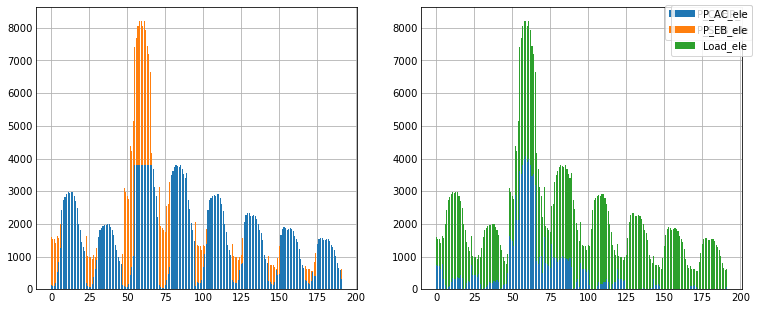

In [18]:
# plot
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(1,2,figsize=(10,4))

# ax.plot(Load_scene, np.sum(P_CCHP_gas.values,axis=1), linewidth=2.0)

P_CCHP_gas_all=np.sum(P_CCHP_gas.values,axis=1)
P_SUB_electricity_all=np.sum(P_SUB_electricity.values,axis=1)
P_GB_gas_all=np.sum(P_GB_gas.values,axis=1)
P_AC_electricity_all=np.sum(P_AC_electricity.values,axis=1)
P_EB_electricity_all=np.sum(P_EB_electricity.values,axis=1)

P_SUB_e=np.zeros((Max_Load_scene,subTypes))
P_CCHP_e=np.zeros((Max_Load_scene,cchpTypes))
P_CCHP_c=np.zeros((Max_Load_scene,cchpTypes))
P_CCHP_h=np.zeros((Max_Load_scene,cchpTypes))

for i in SUB_types:
    P_SUB_e[:,i]=CMatrix[0,i]*P_SUB_electricity.values[:,i]
for i in CCHP_types:
    j = i+subTypes
    P_CCHP_e[:,i]=CMatrix[0,j]*P_CCHP_gas.values[:,i]
    P_CCHP_c[:,i]=CMatrix[1,j]*P_CCHP_gas.values[:,i]
    P_CCHP_h[:,i]=CMatrix[2,j]*P_CCHP_gas.values[:,i]

b1 = ax[0].bar(Load_scene, np.sum(P_CCHP_e,axis=1), width=0.7, label= 'P_CCHP_e')
b2 = ax[0].bar(Load_scene, P_SUB_electricity_all, width=0.7, bottom=np.sum(P_CCHP_e,axis=1), label= 'P_SUB_ele')

b3 = ax[1].bar(Load_scene, P_AC_electricity_all, width=0.7, label= 'P_AC_ele')
b4 =ax[1].bar(Load_scene, P_EB_electricity_all, width=0.7, bottom=P_AC_electricity_all, label= 'P_EB_ele')
b5 =ax[1].bar(Load_scene, np.ravel(Load_E), width=0.7, bottom=P_AC_electricity_all+P_EB_electricity_all, label= 'Load_ele')

fig.legend((b1,b2), ('P_CCHP_e','P_SUB_ele'),'upper right')
fig.legend((b3,b4,b5), ('P_AC_ele','P_EB_ele','Load_ele'),'upper right')

plt.show()


In [11]:
# 保存求解结果到txt文件中
np.savetxt("./results/X_CCHP.txt",X_CCHP.values,fmt='%.1e',delimiter=',')
np.savetxt("./results/X_GB",X_GB.values,fmt='%.1e',delimiter=',')
np.savetxt("./results/X_AC",X_AC.values,fmt='%.1e',delimiter=',')
np.savetxt("./results/X_EB",X_EB.values,fmt='%.1e',delimiter=',')
np.savetxt("./results/X_SUB",X_SUB.values,fmt='%.1e',delimiter=',')

np.savetxt("./results/P_CCHP_gas",P_CCHP_gas.values,fmt='%.4e',delimiter=',')
np.savetxt("./results/V_CCHP_gas",V_CCHP_gas.values,fmt='%.4e',delimiter=',')
np.savetxt("./results/P_SUB_electricity",P_SUB_electricity.values,fmt='%.4e',delimiter=',')
np.savetxt("./results/P_GB_gas",P_GB_gas.values,fmt='%.4e',delimiter=',')
np.savetxt("./results/V_GB_gas",V_GB_gas.values,fmt='%.4e',delimiter=',')
np.savetxt("./results/P_AC_electricity",P_AC_electricity.values,fmt='%.4e',delimiter=',')
np.savetxt("./results/P_EB_electricity",P_EB_electricity.values,fmt='%.4e',delimiter=',')

np.savetxt("./results/P",P.values,fmt='%.4e',delimiter=',')
np.savetxt("./results/L",L.values,fmt='%.4e',delimiter=',')